# *Trabalho de Aprendizagem Não Supervisionada*
### **Objetivo**: 
Com uma base de fotos de pessoas de diferentes famílias, baseado em um arquivo que informa o parentesco entre elas, treinar uma rede para receber fotos, de duas em duas, e informar se essas pessoas são parentes (1) ou não (0). 

### **Integrantes**:
- Christian Sommer Bueno (1831143062) 
- Cleber Coradeli (1831143036)
- Fábio Rogerio Zilli (1831143063)
- Guilherme Alves Milreu (1831143045)
- Rodrigo Mendes de Faria (1831143029)

### Concepção
A ideia utilizada nesse estudo é utilizando a técninca de convoluções, extrair caracteristicas das imagens, sumarizá-las em um vetor por imagem e após isso, verificar a distância entre os vetores. Utilizamos como base os kernels [One-shot approach to tackle kinship problem](https://www.kaggle.com/thanatoz/one-shot-method-to-tackle-kinship-problem-keras) e [VGGFace baseline in Keras](https://www.kaggle.com/ateplyuk/vggface-baseline-in-keras) além de aprofundar os conhecimento com o tópico [CNN with Keras](https://www.kaggle.com/amarjeet007/visualize-cnn-with-keras).

In [0]:
# Importando as blibliotecas
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
from PIL import Image
from keras import backend as K
import keras
from keras.models import Model
from keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dropout, Activation

Using TensorFlow backend.


In [0]:
# Conectando com o google drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [0]:
# Dados na base de testes
TEST_BASE='/content/drive/My Drive/Colab Notebooks/Projeto_Aprendizagem_N_Superv_1/test/'
test_images_names = os.listdir(TEST_BASE)
print(len(test_images_names))
test_images_names[:5]

6282


['face05280.jpg',
 'face05279.jpg',
 'face05281.jpg',
 'face05285.jpg',
 'face05286.jpg']

In [0]:
# Carregando o arquivo de submission
submission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projeto_Aprendizagem_N_Superv_1/sample_submission.csv')
req_mapping = [i.split('-') for i in submission.img_pair]
req_mapping[:5]

[['face05508.jpg', 'face01210.jpg'],
 ['face05750.jpg', 'face00898.jpg'],
 ['face05820.jpg', 'face03938.jpg'],
 ['face02104.jpg', 'face01172.jpg'],
 ['face02428.jpg', 'face05611.jpg']]

In [0]:
# Funções que serão usada no processamento
# Carregar a imagem
def load_img(PATH): return np.array(Image.open(PATH))

In [0]:
# Cálculo da distância usando linalg.norm
def distance(x, y):
    return np.linalg.norm(x - y)

In [0]:
# Definição da re com o modelo pré-treinado VGG
K.set_image_data_format('channels_first')
def vgg_face(weights_path=None):
    img = Input(shape=(3, 224, 224))

    pad1_1 = ZeroPadding2D(padding=(1, 1))(img)
    conv1_1 = Convolution2D(64, (3, 3), activation='relu', name='conv1_1')(pad1_1)
    pad1_2 = ZeroPadding2D(padding=(1, 1))(conv1_1)
    conv1_2 = Convolution2D(64, (3, 3), activation='relu', name='conv1_2')(pad1_2)
    pool1 = MaxPooling2D((2, 2), strides=(2, 2))(conv1_2)

    pad2_1 = ZeroPadding2D((1, 1))(pool1)
    conv2_1 = Convolution2D(128, (3, 3), activation='relu', name='conv2_1')(pad2_1)
    pad2_2 = ZeroPadding2D((1, 1))(conv2_1)
    conv2_2 = Convolution2D(128, (3, 3), activation='relu', name='conv2_2')(pad2_2)
    pool2 = MaxPooling2D((2, 2), strides=(2, 2))(conv2_2)

    pad3_1 = ZeroPadding2D((1, 1))(pool2)
    conv3_1 = Convolution2D(256, (3, 3), activation='relu', name='conv3_1')(pad3_1)
    pad3_2 = ZeroPadding2D((1, 1))(conv3_1)
    conv3_2 = Convolution2D(256, (3, 3), activation='relu', name='conv3_2')(pad3_2)
    pad3_3 = ZeroPadding2D((1, 1))(conv3_2)
    conv3_3 = Convolution2D(256, (3, 3), activation='relu', name='conv3_3')(pad3_3)
    pool3 = MaxPooling2D((2, 2), strides=(2, 2))(conv3_3)

    pad4_1 = ZeroPadding2D((1, 1))(pool3)
    conv4_1 = Convolution2D(512, (3, 3), activation='relu', name='conv4_1')(pad4_1)
    pad4_2 = ZeroPadding2D((1, 1))(conv4_1)
    conv4_2 = Convolution2D(512, (3, 3), activation='relu', name='conv4_2')(pad4_2)
    pad4_3 = ZeroPadding2D((1, 1))(conv4_2)
    conv4_3 = Convolution2D(512, (3, 3), activation='relu', name='conv4_3')(pad4_3)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2))(conv4_3)

    pad5_1 = ZeroPadding2D((1, 1))(pool4)
    conv5_1 = Convolution2D(512, (3, 3), activation='relu', name='conv5_1')(pad5_1)
    pad5_2 = ZeroPadding2D((1, 1))(conv5_1)
    conv5_2 = Convolution2D(512, (3, 3), activation='relu', name='conv5_2')(pad5_2)
    pad5_3 = ZeroPadding2D((1, 1))(conv5_2)
    conv5_3 = Convolution2D(512, (3, 3), activation='relu', name='conv5_3')(pad5_3)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2))(conv5_3)

    fc6 = Convolution2D(4096, (7, 7), activation='relu', name='fc6')(pool5)
    fc6_drop = Dropout(rate = 0.5)(fc6)
    fc7 = Convolution2D(4096,( 1, 1), activation='relu', name='fc7')(fc6_drop)
    fc7_drop = Dropout(rate = 0.5)(fc7)
    fc8 = Convolution2D(2622, (1, 1), name='fc8')(fc7_drop)
    flat = Flatten()(fc8)
    out = Activation('softmax')(flat)

    model = Model(input=img, output=out)

    if weights_path:
        model.load_weights(weights_path)

    return model

In [0]:
vgg_facenet = vgg_face('/content/drive/My Drive/Colab Notebooks/Projeto_Aprendizagem_N_Superv_1/vgg-face-keras.h5')

W0624 06:09:35.872129 140717788649344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0624 06:09:35.909316 140717788649344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0624 06:09:35.923514 140717788649344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0624 06:09:35.937055 140717788649344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0624 06:09:35.938036 1407177886

In [0]:
vgg_facenet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 3, 226, 226)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 226, 226)      0         
_________________________________________________________________
conv1_2 (Conv2D)             (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 64, 114, 114)      0         
__________

In [0]:
# Carregando a base de teste
test_images = os.listdir(TEST_BASE)
test = np.array([load_img(os.path.join(TEST_BASE, i)) for i in test_images])
# Extraindo as características
test_emb = vgg_facenet.predict(test.transpose(0,3,1,2))

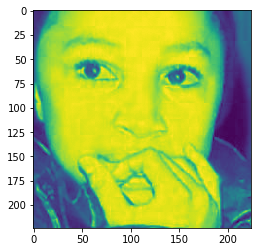

In [0]:
# Imagem original, antes da extração de características
CHOOSED_IMG = 0
plt.imshow(test[CHOOSED_IMG][:,:,0]);

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


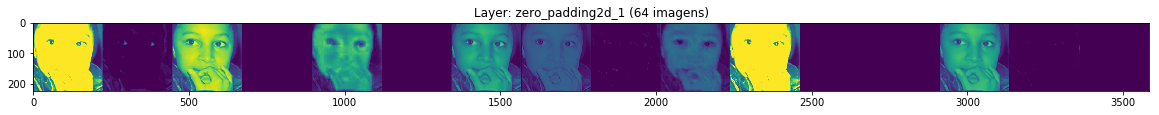

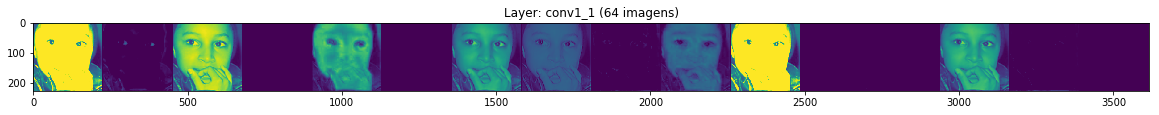

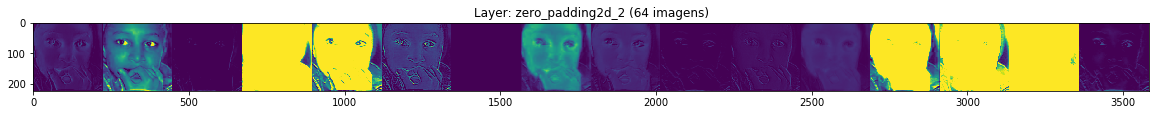

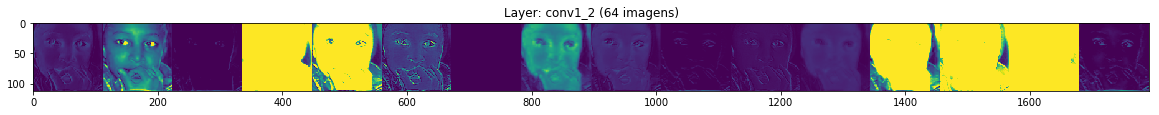

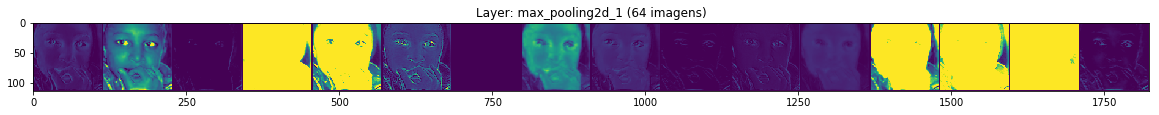

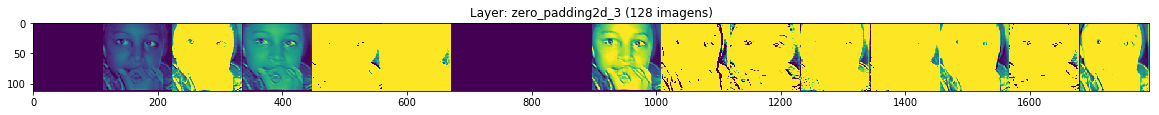

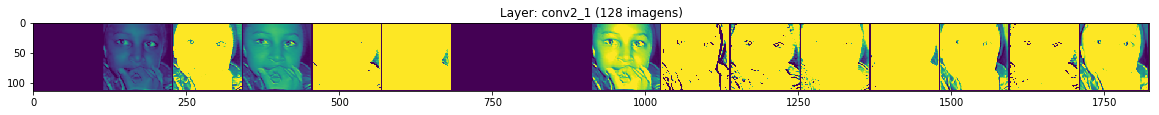

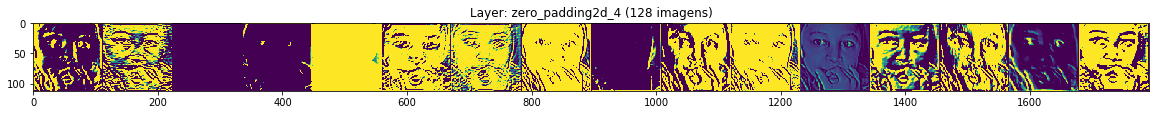

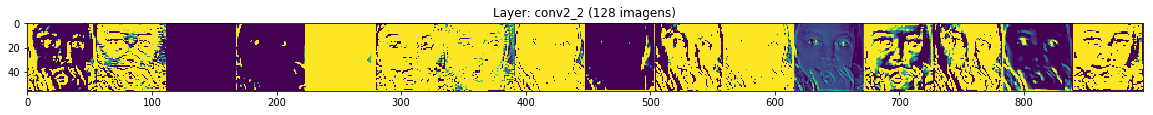

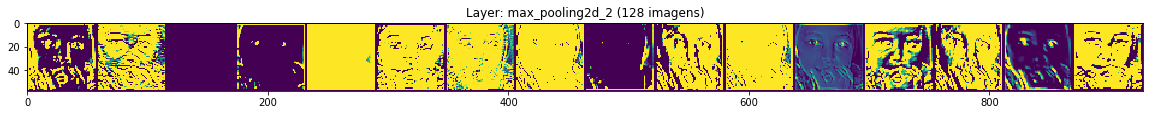

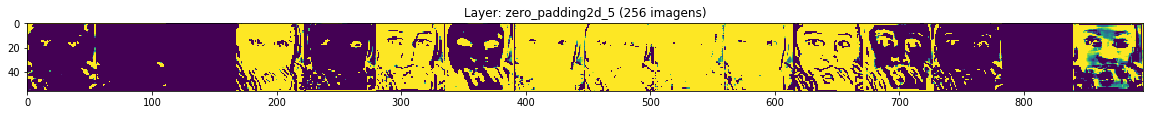

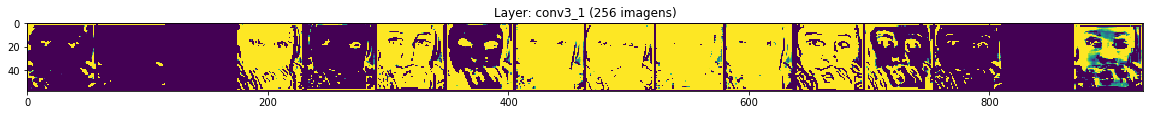

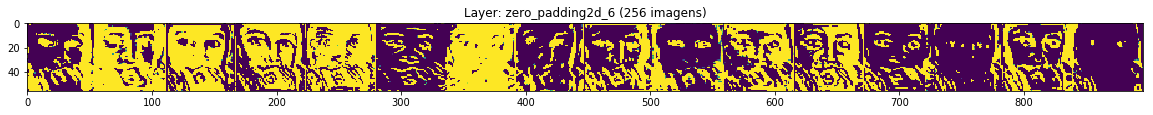

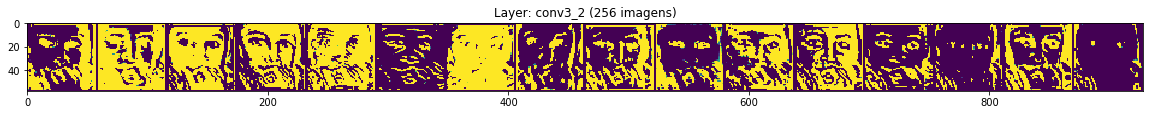

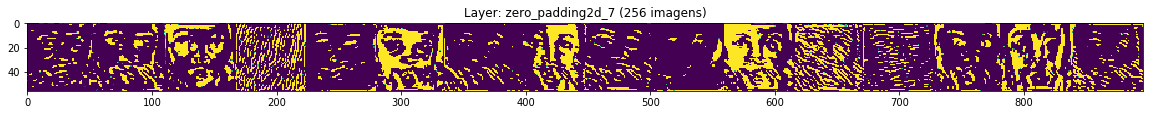

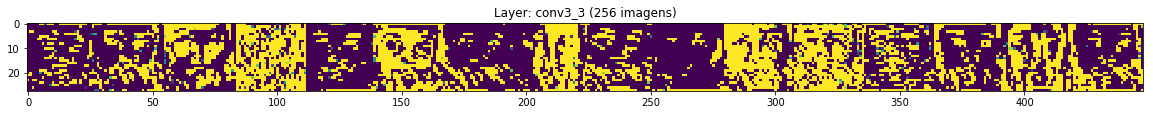

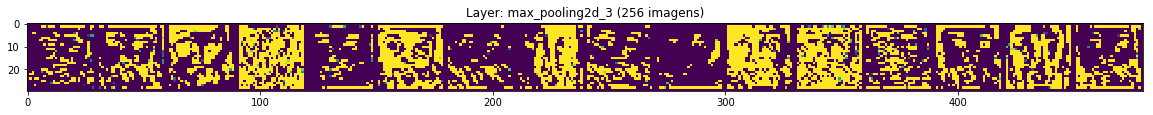

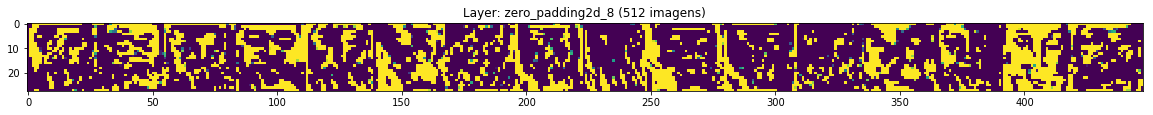

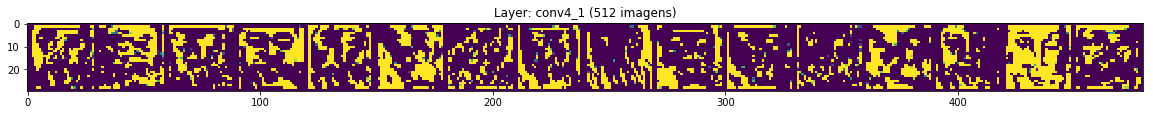

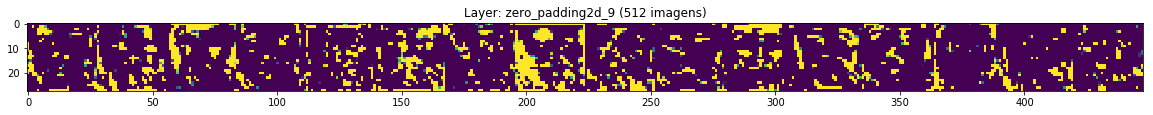

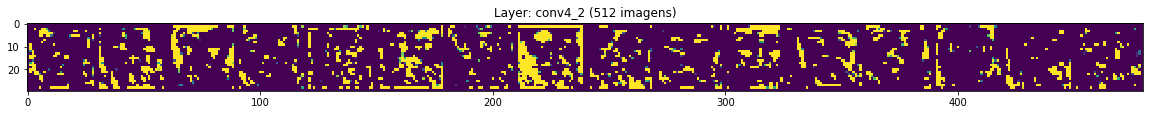

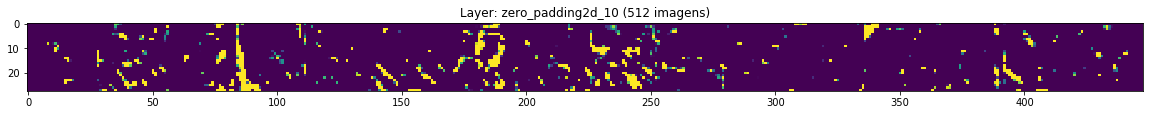

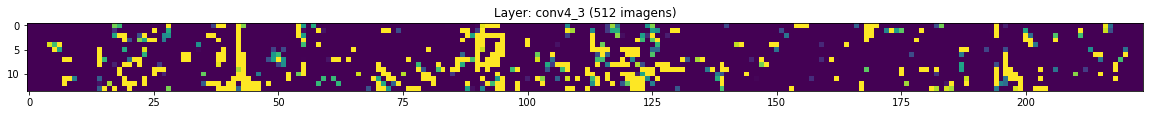

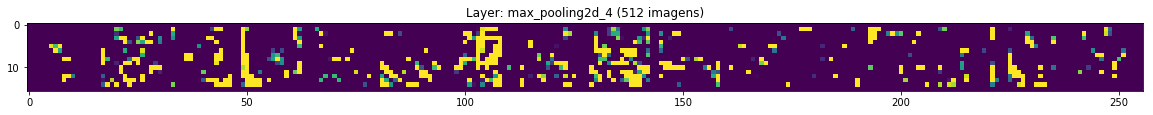

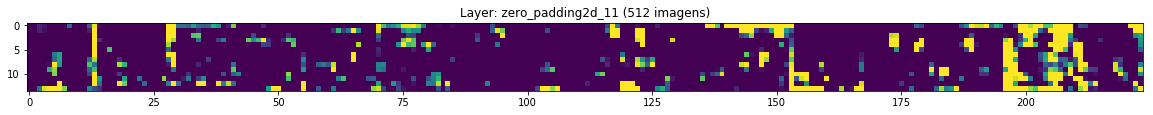

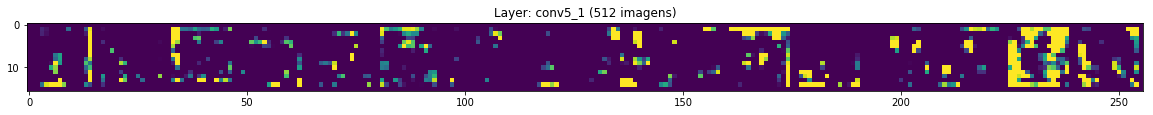

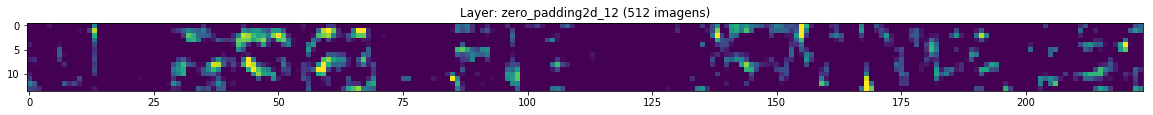

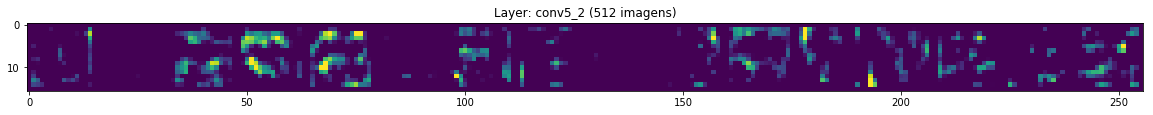

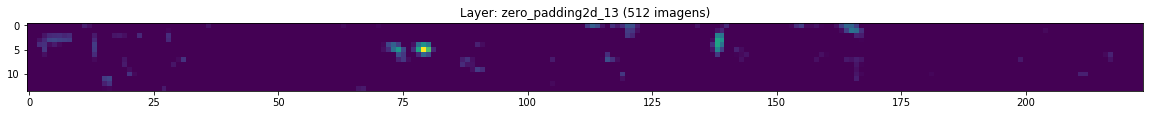

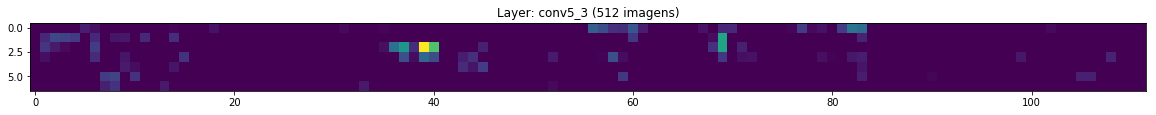

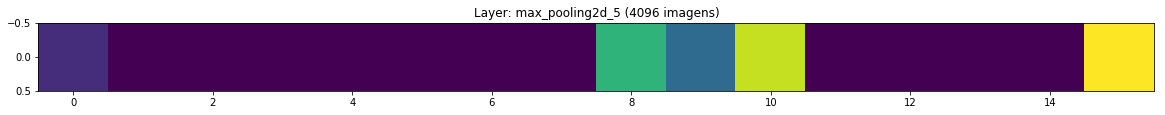

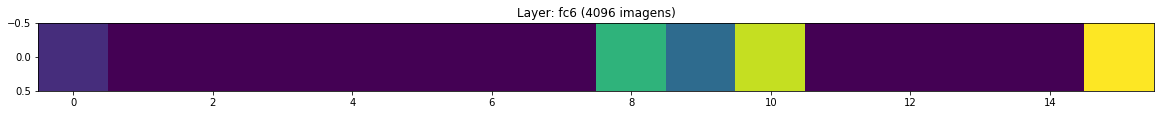

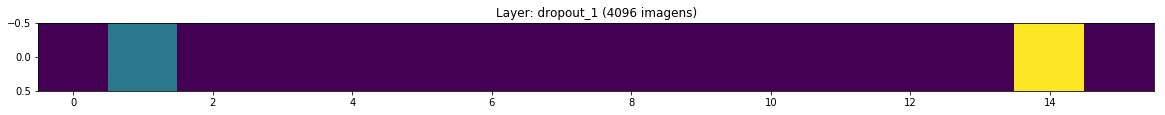

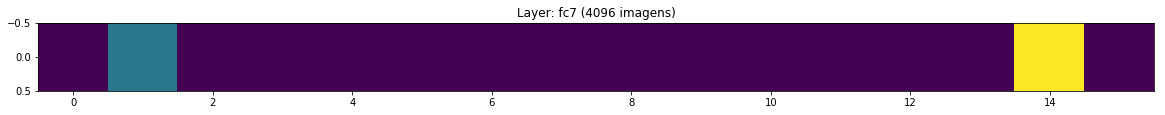

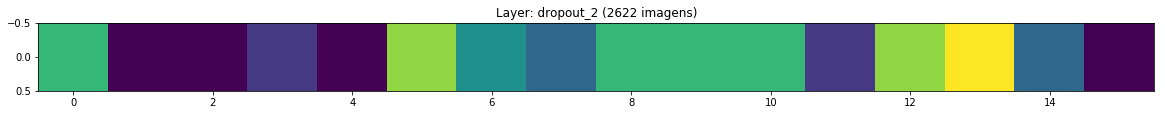

In [0]:
# Demonstração da passagem pelas camadas da rede
# Optamos por mostrar apenas 16 imagens de cada layer para reduzir o processamento e a utilização de memória.
from keras.models import Model
layer_outputs = [layer.output for layer in vgg_facenet.layers[1:]]
layer_names = [layer.name for layer in vgg_facenet.layers]
activation_model = Model(inputs=vgg_facenet.input, outputs=layer_outputs)
activations = activation_model.predict(test.transpose(0,3,1,2))

for layer_name, feature_map in zip(layer_names[1:], activations[1:]):
  if len(feature_map.shape) == 4:
    
    n_features = feature_map.shape[1]
    size = feature_map.shape[2]
    real_n_features = n_features
    n_features = 16 if n_features > 16 else n_features
    display_grid = np.zeros((size, size * n_features))
    
    for i in range(n_features):
      x = feature_map[CHOOSED_IMG, i, :, :]
      x = np.clip(x, 0, 255).astype('uint8')
      
      display_grid[:, i * size : (i + 1) * size] = x
    
    scale = 20. / 16
    plt.figure(figsize=(scale * n_features, scale))
    plt.title('Layer: ' + layer_name + ' ('+str(real_n_features)+' imagens)')
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [0]:
# Criando um mapa com todas as imagens para facilitar a manipulação
image_mapping = {img:idx for idx, img in enumerate(test_images)}

In [0]:
# Subtração do embed de cada imagem do arquivo de submissão.
vector_distances=[]
for i in req_mapping:
    dis = distance(test_emb[image_mapping[i[0]]], test_emb[image_mapping[i[1]]])
    vector_distances.append(dis)
vector_distances=np.array(vector_distances)

In [0]:
# Escolhemos que, se o resultado é menor que 0.7, então não considera que são parentes, ou seja, fica com '0' no arquivo. Caso contrário, fica com '1'
total_sum = vector_distances.sum()
probs = []
for dist in vector_distances:
    prob = np.sum(vector_distances[np.where(vector_distances <= dist)[0]])/total_sum
    
    if (1 - prob) <= 0.7:
        probs.append(0)
    else:
        probs.append(1)
        
submission.is_related = probs

In [0]:
# Gravando o resultado das probabilidades calculadas no arquivo submission.csv
submission.to_csv('/content/drive/My Drive/Colab Notebooks/Projeto_Aprendizagem_N_Superv_1/submission.csv', index=False)

# Conclusão: 
O melhor resultado de submissão que conseguimos foi 52%.     
Entendemos que apesar de termos seguido a técnica corretamente alguns ponto precisão ser ajustados. É possível perceber na parte de vizualiação da extração de características que no final praticamente não sobrou informação tratável. O que pode significar o motivo do baixo score.    
Ainda apesar de todas as subimissões terem ficado acima dos 50% é difícil dizer se a técnica funcionou ou se foi "sorte" dado que é esperada uma média de 50% de acerto para uma base como essa.

## Próximos passos
- Ajustar as camadas da rede, visando dimunior a perda de informação.
- Testar outras formas de comparação como similaridade de cosseno e cálculo de distancia euclidiana.